In [1]:
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm


from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from wordcloud import WordCloud

# Data Gathering

In [2]:
from google.colab import drive  
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd '/content/drive/My Drive/NLP'
!ls -la

/content/drive/My Drive/NLP
total 4
drwx------ 2 root root 4096 Feb 12 11:42 data


In [4]:
def fnc(path_headlines, path_bodies):

    map = {'agree': 0, 'disagree':1, 'discuss':2, 'unrelated':3}

    with open(path_bodies, encoding='utf_8') as fb:  # Body ID,articleBody
        body_dict = {}
        lines_b = csv.reader(fb)
        for i, line in enumerate(tqdm(list(lines_b), ncols=80, leave=False)):
            if i > 0:
                body_id = int(line[0].strip())
                body_dict[body_id] = line[1]

    with open(path_headlines, encoding='utf_8') as fh: # Headline,Body ID,Stance
        lines_h = csv.reader(fh)
        h = []
        b = []
        l = []
        for i, line in enumerate(tqdm(list(lines_h), ncols=80, leave=False)):
            if i > 0:
                body_id = int(line[1].strip())
                label = line[2].strip()
                if label in map and body_id in body_dict:
                    h.append(line[0])
                    l.append(map[line[2]])
                    b.append(body_dict[body_id])
    return h, b, l

data_dir = './data'
headlines, bodies, labels = fnc(
    os.path.join(data_dir, 'combined_stances_train.csv'),
    os.path.join(data_dir, 'combined_bodies_train.csv')
)

list_of_tuples = list(zip(headlines, bodies, labels))
df = pd.DataFrame(list_of_tuples, columns=['text_a', 'text_b', 'label'])
train_df, val_df = train_test_split(df)
labels_val = pd.Series(val_df['label']).to_numpy()

headlines, bodies, labels = fnc(
    os.path.join(data_dir, 'combined_stances_test.csv'),
    os.path.join(data_dir, 'combined_bodies_test.csv')
)

list_of_tuples = list(zip(headlines, bodies, labels))
test_df = pd.DataFrame(list_of_tuples, columns=['text_a', 'text_b', 'label'])
labels_test = pd.Series(test_df['label']).to_numpy()

In [7]:
train_df

,text_a,text_b,label
20163,Michael Phelps' girlfriend was born male but d...,After being officially dead for 48 minutes and...,3
2765,Angry mob hacks off alleged rapist's genitals ...,"When Apple unveiled its Apple Watch, the compa...",3
14177,AUSTRALIA: 600-POUND WOMAN GIVES BIRTH TO 40-P...,Christian Bale will not be playing Steve Jobs ...,3
59250,Dual citizenship should be allowed,I hold dual citizenship as do two of my three ...,0
16774,"Brian Williams: No, Our Meteorologist Was Not ...",Along with unveiling the Apple Watch earlier t...,3
...,...,...,...
49487,"L. Jinny? Abdel-Majed Abdel Bary, UK Rapper, S...","Over the weekend, NBC anchor Lester Holt cut t...",3
42876,Nicaraguan commission on possible meteorite cr...,"Move over, Netflix and Hulu.\nWord has it that...",3
7607,ISIS Getting Ebola,"On Monday morning, a report surfaced claiming ...",3
60495,College should be free,The clam that marijuana available today is so ...,3


Text(0.5, 1.0, 'Checking if data is balanced or not with a pie chart')

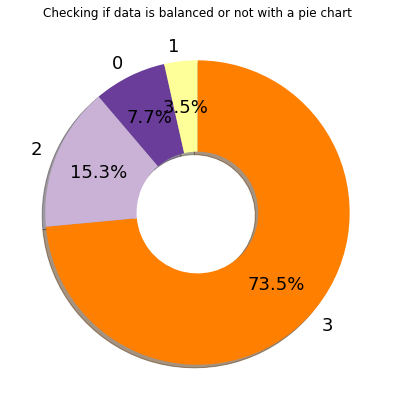

In [9]:
plt.figure(figsize=(7,7))

value_count = train_df["label"].value_counts()


plt.pie(value_count, labels=value_count.index ,
        startangle = 90 ,counterclock =False, wedgeprops = {'width' : 0.6},
        autopct='%1.1f%%', pctdistance = 0.7, textprops = {'color': 'black', 'fontsize' : 18}, 
        shadow = True,colors = sns.color_palette("Paired")[7:])
plt.title("Checking if data is balanced or not with a pie chart")

(-0.5, 399.5, 199.5, -0.5)

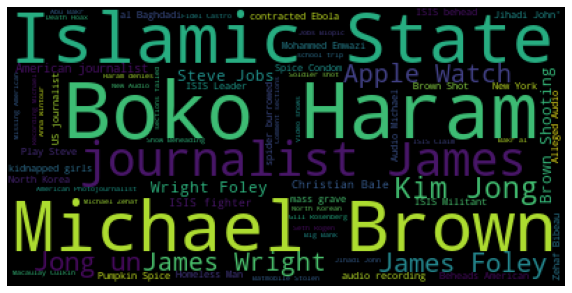

In [13]:
cloud = train_df.text_a.tolist()
cloud_st = " ".join(cloud)
plt.figure(figsize=(10,10))
plt.imshow(WordCloud().generate(cloud_st))
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

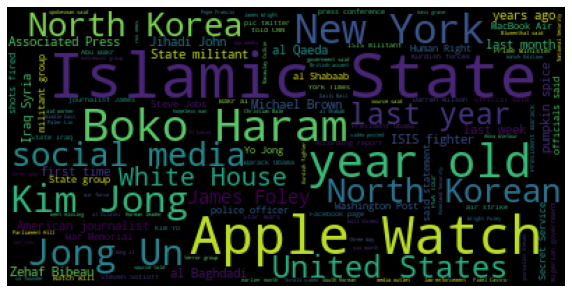

In [14]:
cloud = train_df.text_b.tolist()
cloud_st = " ".join(cloud)
plt.figure(figsize=(10,10))
plt.imshow(WordCloud().generate(cloud_st))
plt.axis("off")